**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**July, 2023**


---

# Preprocessing of all the samples together

scRNA-Seq of Placental explants

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
%matplotlib inline
import seaborn as sns
import seaborn as sb
from glob import iglob
import anndata
import matplotlib as mpl
import skmisc
import gc

    
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = '../results/images/preprocessing/'
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable


fig_path= '../results/images/preprocessing/'

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


In [2]:
def Barplot(which_var, adata, var='identity', height=3, color = False, suffix= ''):
    
    '''
    Function to plot barplots plotting the proportion of cells per catergory in var, coming from each category in which_var.
    
    Parameters:
        which_var: column name in .obs. Contains the categories to contrast.
        adata: anndata object.
        var: column name in .obs. It contains the categories of the cells.
        height: plot height
        color: colors to use
        suffix: string. Suffix to be added at the end of the name of the plot.
    
    Return:
        Saves bar plot as a pdf.
        
    '''
    
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+ suffix+'.pdf', bbox_inches='tight',
                       dpi=300, orientation='landscape', format= 'pdf', optimize=True)

### Import data

In [3]:
adata_Tg = sc.read('../data/rna1_counts_Tg_adata.h5ad')
adata_Lm = sc.read('../data/rna1_counts_Lm_adata.h5ad')
adata_Pf = sc.read('../data/rna1_counts_Pf_adata.h5ad')

In [4]:
set(adata_Tg.obs["batch"])

{'0', '1', '2', '3'}

In [5]:
set(adata_Lm.obs["batch"])

{'0', '1', '2', '3'}

In [6]:
set(adata_Pf.obs["batch"])

{'0', '1', '2', '3', '4', '5', '6', '7'}

#### Correcting batch numbers for concatenation
As the batch numbers are repeated between infections, I will modify them. The order will be Lm= 0-7. Pf= 8-19. Tg= 20-27

In [7]:
#Function that changes the cluster names as indicated

#Function that changes the cluster names as indicated
adata_Pf.obs['batch'] = (adata_Pf.obs["batch"].map(lambda x: 
                            {"0": "8", "1": "9",  "2": "10", "3":"11", "4":"12", "5":"13", "6":"14", "7":"15", "8":"16",
                            "9":"17", "10":"18", "11":"19"}
                            .get(x, x)).astype("category"))

#Function that changes the cluster names as indicated
adata_Tg.obs['batch'] = (adata_Tg.obs["batch"].map(lambda x: 
                            {"0": "20", "1": "21", "2":"22", "3":"23",
                            "4": "24", "5": "25", "6":"26", "7":"27"}
                            .get(x, x)).astype("category"))

### Subsetting only the hs genes taken from the Lm object

In [8]:
#Keeping hs genes only
#adata_Tg= adata_Tg[:, list(adata_Lm.var.index)].copy()

In [9]:
#The intersection will only be hs genes
hsGenes= list(set(adata_Lm.var.index).intersection(set(adata_Pf.var.index)))

In [10]:
#Pf data has less genes due to Reginas preprocessing. Keeping only those ones
adata_Lm= adata_Lm[:, hsGenes].copy()
adata_Pf= adata_Pf[:, hsGenes].copy()
adata_Tg= adata_Tg[:, hsGenes].copy()

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [11]:
#removing the extra columns in .var corresponding to the Tg preprocessing
adata_Tg.var= adata_Tg.var.drop(columns=['tg','hs','n_cells_by_counts', 'mean_counts','pct_dropout_by_counts','total_counts'])

In [12]:
gc.collect()

1764

### Concatenate datasets

In [13]:
adata_Lm.X= adata_Lm.layers['raw_counts'].copy()
adata_Pf.X= adata_Pf.layers['raw_counts'].copy()
adata_Tg.X= adata_Tg.layers['raw_counts'].copy()

In [14]:
adata = adata_Tg.concatenate(adata_Pf,adata_Lm, index_unique=None)

In [15]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 248970
Total number of genes: 36601


In [16]:
#adata.obs.to_csv('./adataObs.csv')

In [17]:
del(adata_Lm)
del(adata_Pf)
del(adata_Tg)
gc.collect()

1093

# QC plots

In [18]:
## Deleting the cells expressing less than 10 genes
sc.pp.filter_cells(adata, min_genes=10)
print('Total number of cells: {:d}'.format(adata.n_obs))

Total number of cells: 248970


In [19]:
sc.set_figure_params(figsize=(20,10))

... storing 'sample' as categorical
... storing 'stage' as categorical
... storing 'donor' as categorical
... storing 'infection' as categorical
... storing 'assignment_SoC' as categorical
... storing 'donor_id' as categorical
... storing 'infection_stage' as categorical
... storing 'Tg_infected' as categorical


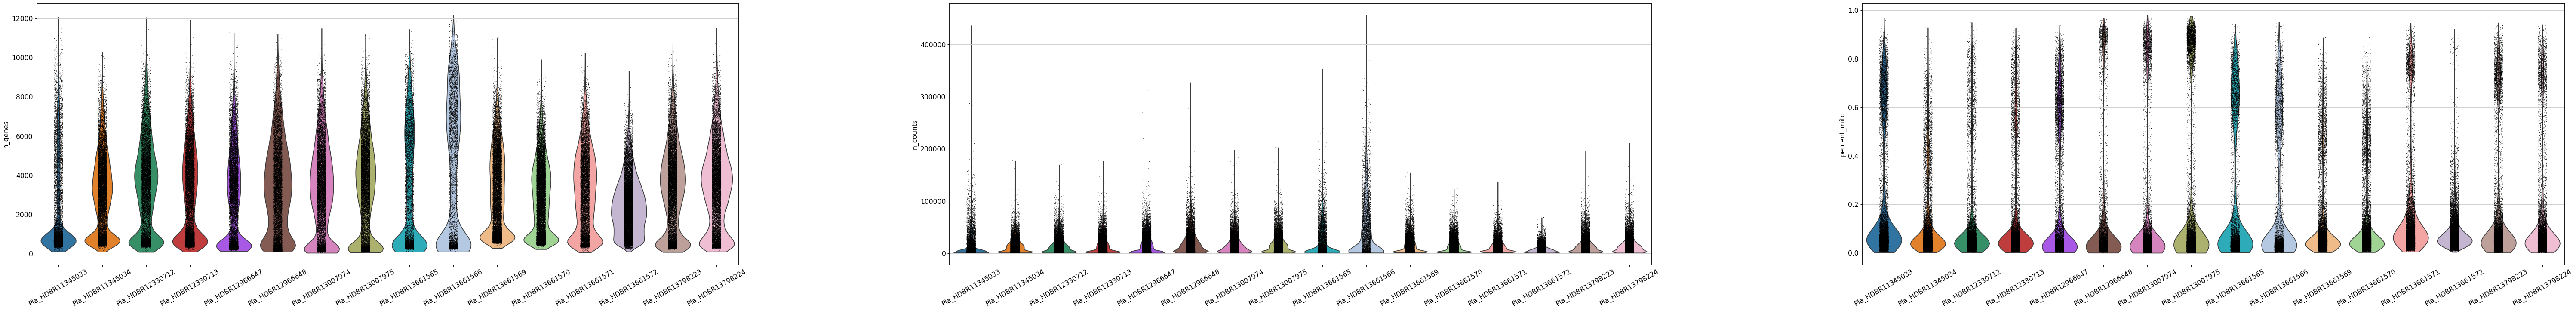

In [20]:
#sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'], groupby='donor_souporcell', rotation=45, save='_before_qc.pdf') 
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'], groupby='sample', rotation=30, save='_before_qc.pdf', wspace=5, ) 

In [21]:
sc.set_figure_params(figsize=(6.4,4.8))

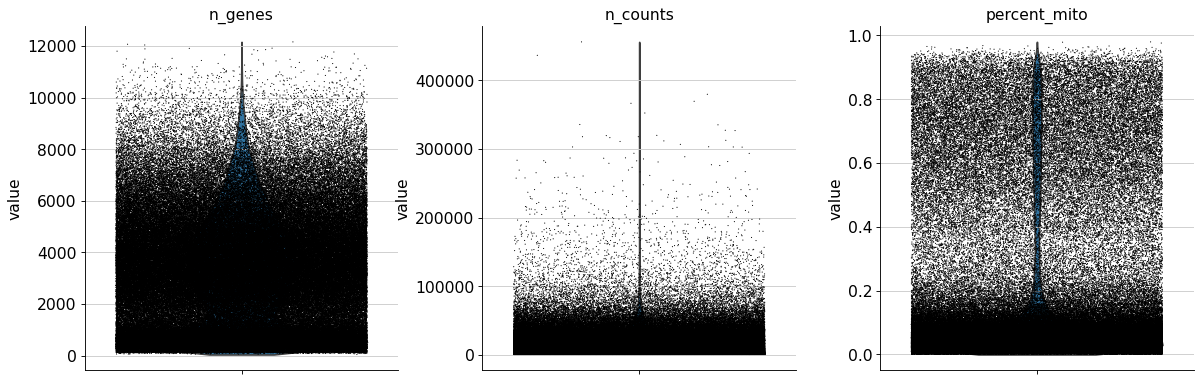

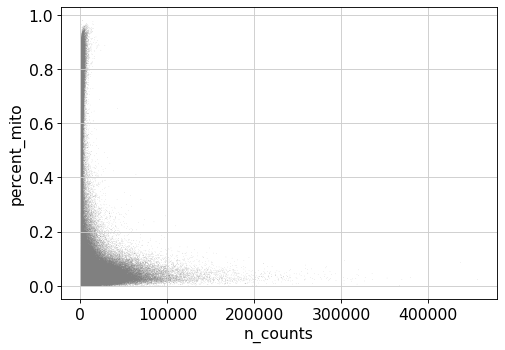

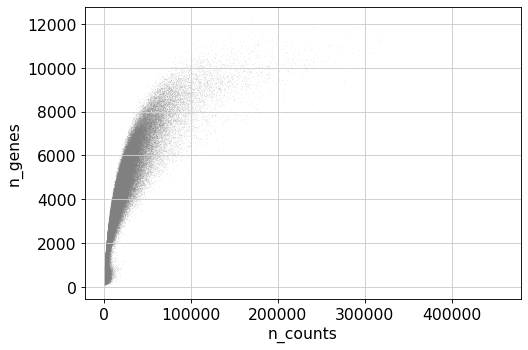

In [22]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True, save='.pdf')
sc.pl.scatter(adata, x='n_counts', y='percent_mito', save='_numi_vs_mito.pdf')
sc.pl.scatter(adata, x='n_counts', y='n_genes', save='_numi_vs_ngenes.pdf')

### Filtering the number of genes

In [23]:
sc.set_figure_params(figsize=(6.4,4.8))

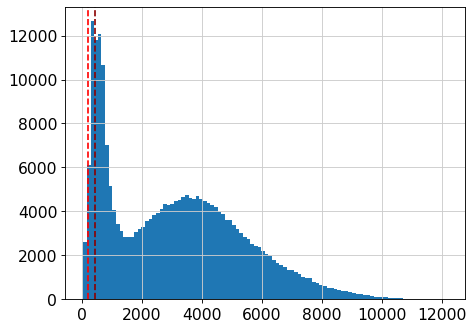

In [24]:
plt.hist(adata.obs['n_genes'], bins = 100)
plt.axvline(200, linestyle = '--', color = 'red')
plt.axvline(450, linestyle = '--', color = 'darkred')

In [25]:
#deleting the cells expressing less than 450 genes
sc.pp.filter_cells(adata, min_genes=450)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


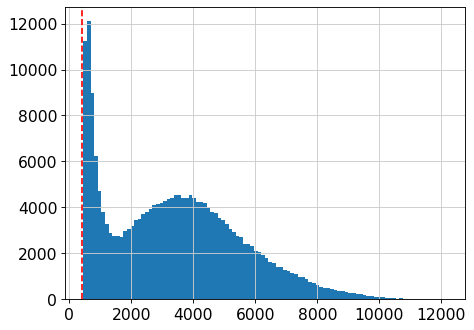

In [26]:
plt.hist(adata.obs['n_genes'], bins = 100)
plt.axvline(400, linestyle = '--', color = 'red')

In [27]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
#adata.obs['donor_souporcell'].values.describe()
adata.obs['sample'].values.describe()

Total number of cells: 223337
Total number of genes: 36601


,counts,freqs
categories,,
Pla_HDBR11345033,12741,0.057048
Pla_HDBR11345034,17422,0.078008
Pla_HDBR12330712,13386,0.059936
Pla_HDBR12330713,15645,0.070051
Pla_HDBR12966647,12535,0.056126
Pla_HDBR12966648,10533,0.047162
Pla_HDBR13007974,13025,0.058320
Pla_HDBR13007975,13738,0.061512
Pla_HDBR13661565,6065,0.027156



### Filter cells by counts

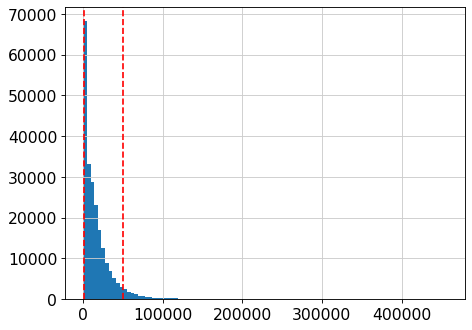

In [28]:
plt.hist(adata.obs['n_counts'], bins = 100)
plt.axvline(1000, linestyle = '--', color = 'red')
plt.axvline(50000, linestyle = '--', color = 'red')

In [29]:
sc.pp.filter_cells(adata, min_counts = 1000)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

#sc.pp.filter_cells(adata, max_counts = 50000)
#print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Number of cells after min count filter: 214962


In [30]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 214962
Total number of genes: 36601



### Filter cells with large % mitochondrial genes

In [31]:
sc.set_figure_params(figsize=(8.5,4.8))

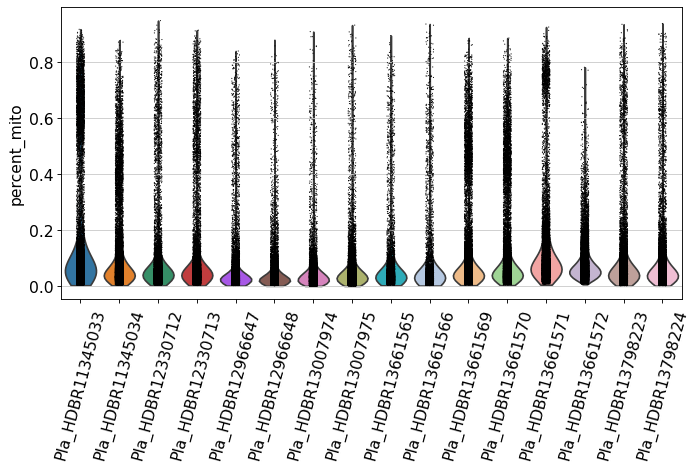

In [32]:
sc.pl.violin(adata, ['percent_mito'], groupby='sample', rotation=75 ) #

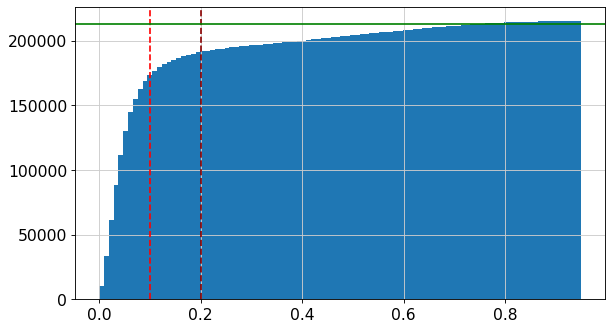

In [33]:
#Histogram Y number of cells, X mitocondrial percentage
plt.hist(adata.obs['percent_mito'], bins = 100, cumulative=True)
plt.axvline(0.1, linestyle = '--', color = 'red')
plt.axvline(0.2, linestyle = '--', color = 'darkred')
plt.axhline(adata.n_obs*0.99, linestyle = '-', color = 'green')

In [34]:
# Keeping cells with <10%
adata = adata[adata.obs['percent_mito'] < 0.2, :]

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [35]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor'].values.describe()
pd.DataFrame(adata.obs).to_csv(str(sc.settings.figdir)+'/metadata_filtered.csv')

Total number of cells: 190897
Total number of genes: 36601


In [36]:
adata

View of AnnData object with n_obs × n_vars = 190897 × 36601
    obs: 'sample', 'stage', 'donor', 'hpi', 'infection', 'percent_mito', 'n_counts', 'batch', 'sample_barcode', 'assignment_SoC', 'donor_id', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'infection_stage', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_hs', 'pct_counts_hs', 'total_counts_tg', 'pct_counts_tg', 'Tg_infected', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mean-0', 'std-0', 'mean-1', 'std-1', 'mean-2', 'std-2'
    uns: 'sample_colors'
    layers: 'raw_counts'

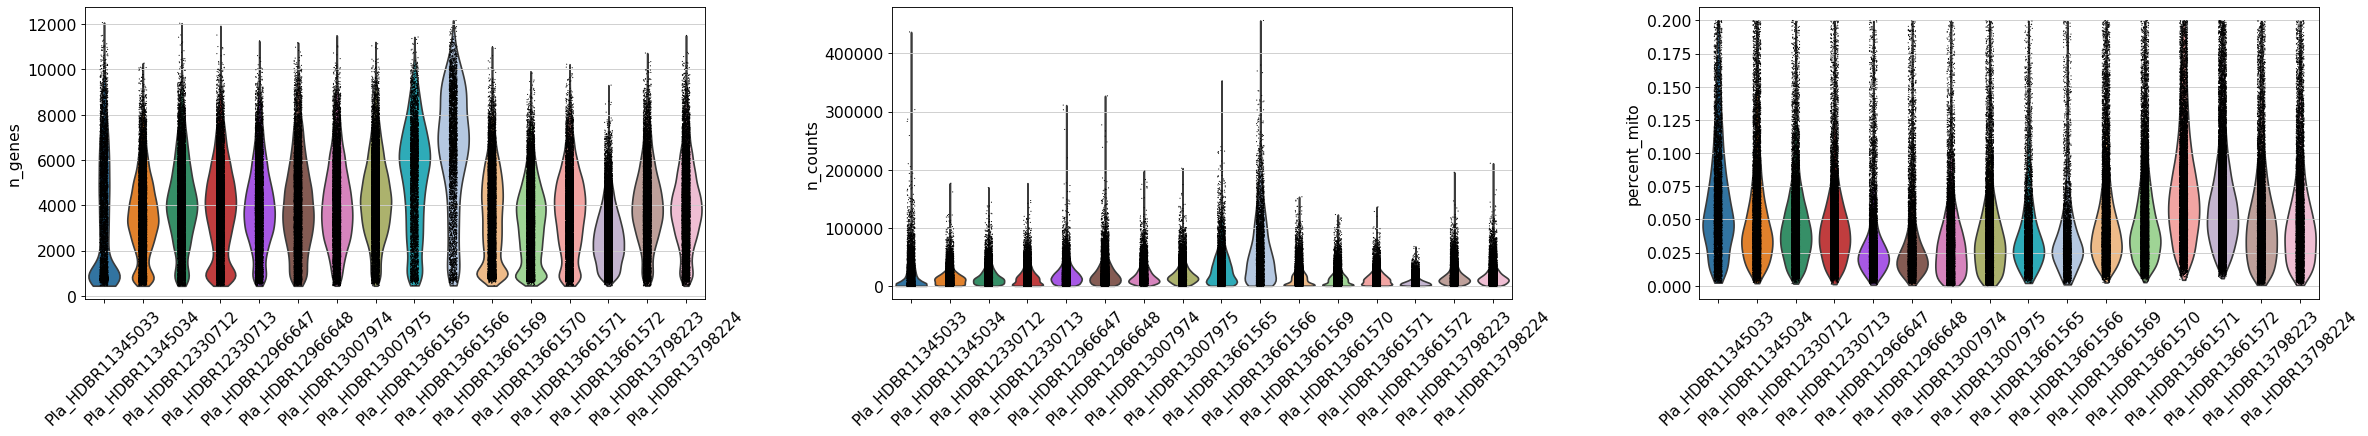

Trying to set attribute `.uns` of view, copying.


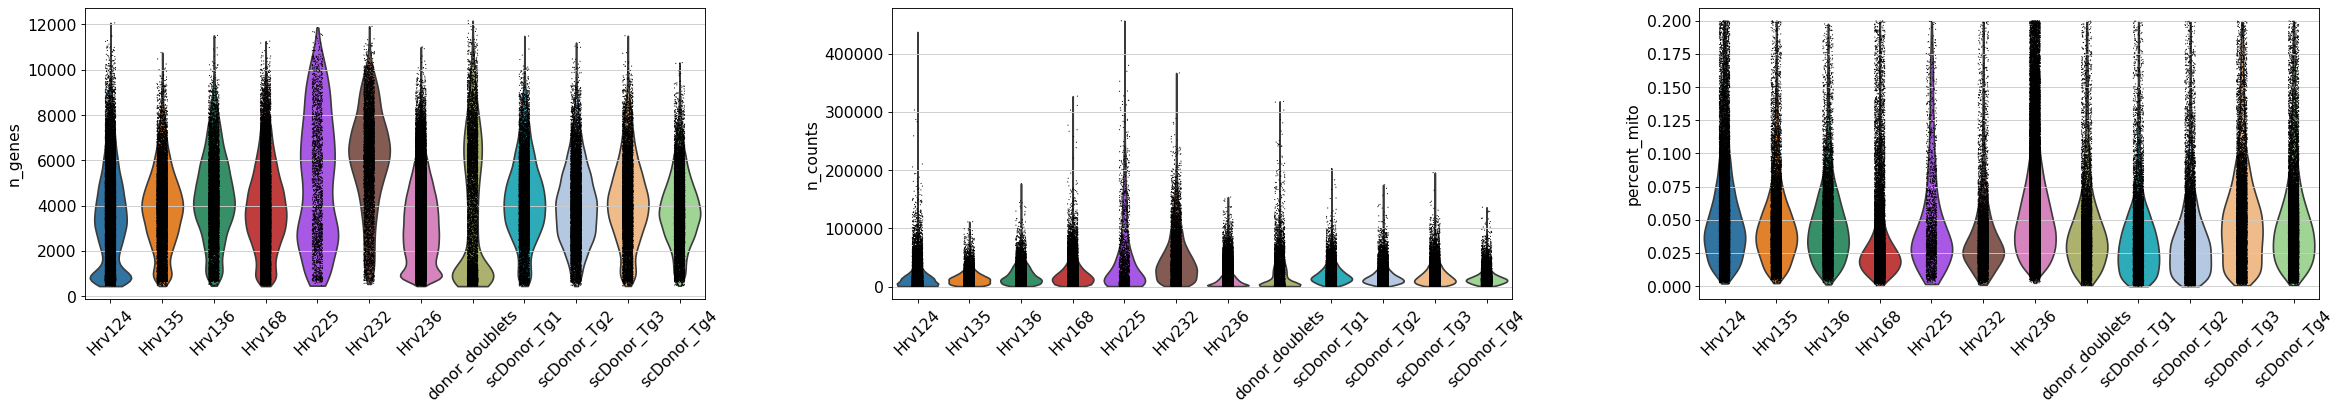

In [37]:
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'], groupby='sample', rotation=45, save='_afterQC_Sample.pdf')
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'], groupby='donor_id', rotation=45, save='_afterQC_Donor.pdf') 

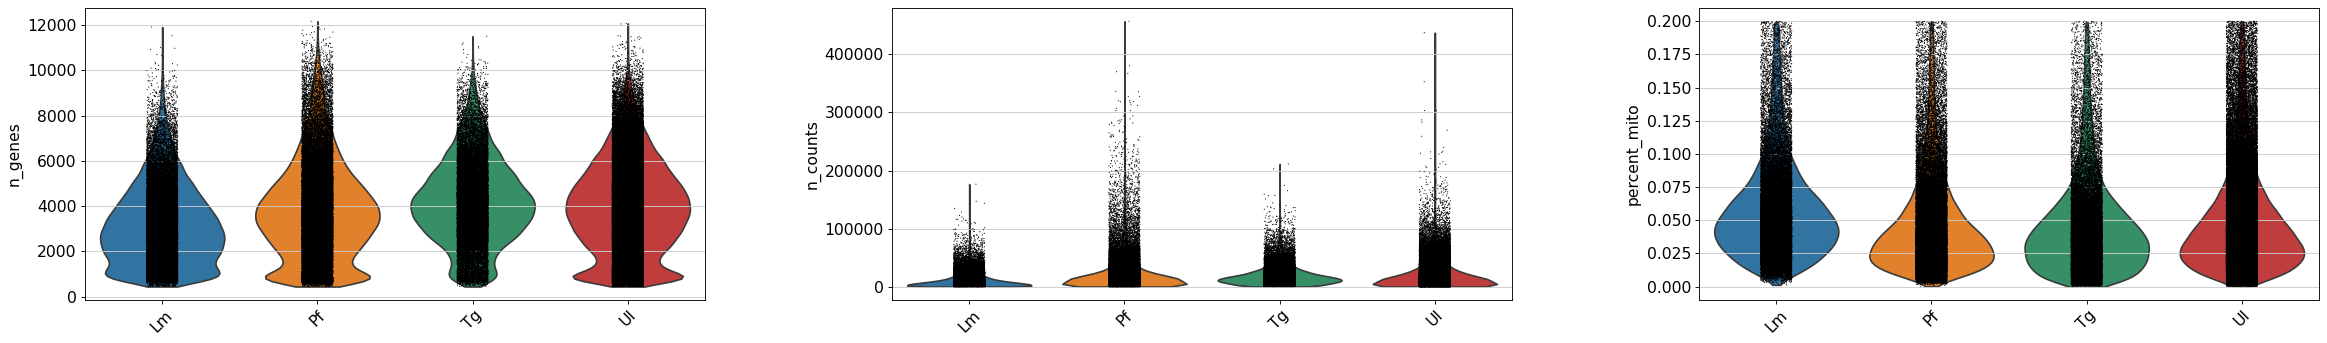

In [38]:
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'], groupby='infection', rotation=45, save='_afterQC_Infection.pdf')

In [39]:
adata.obs['sample'].values.describe()

,counts,freqs
categories,,
Pla_HDBR11345033,6672,0.034951
Pla_HDBR11345034,14138,0.074061
Pla_HDBR12330712,11191,0.058623
Pla_HDBR12330713,12808,0.067094
Pla_HDBR12966647,11234,0.058848
Pla_HDBR12966648,9858,0.051640
Pla_HDBR13007974,12572,0.065858
Pla_HDBR13007975,13014,0.068173
Pla_HDBR13661565,5094,0.026685


In [40]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor_id'].values.describe()
#adata.obs['donor_souporcell'].values.describe()

Total number of cells: 190897
Total number of genes: 36601


,counts,freqs
categories,,
Hrv124,20810,0.109012
Hrv135,11899,0.062332
Hrv136,9247,0.048440
Hrv168,21092,0.110489
Hrv225,2117,0.011090
Hrv232,6423,0.033646
Hrv236,64175,0.336176
donor_doublets,7677,0.040215
scDonor_Tg1,10557,0.055302


## Highly variable genes


In [41]:
#sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
#sc.pp.log1p(adata)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


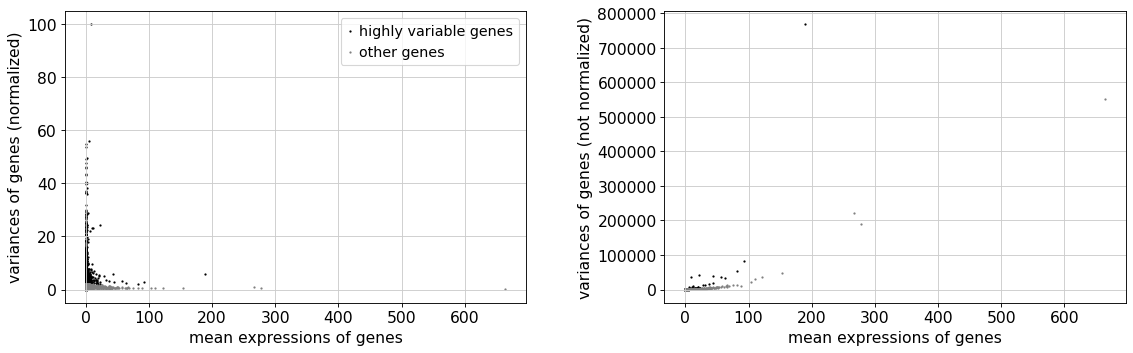

Total number of cells: 190897
Total number of genes: 36601


In [42]:
#  HVGs. Seurat 3 expects non-normalized counts
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor='seurat_v3')
sc.pl.highly_variable_genes(adata)


print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

In [43]:
adata

AnnData object with n_obs × n_vars = 190897 × 36601
    obs: 'sample', 'stage', 'donor', 'hpi', 'infection', 'percent_mito', 'n_counts', 'batch', 'sample_barcode', 'assignment_SoC', 'donor_id', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'infection_stage', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'total_counts', 'total_counts_hs', 'pct_counts_hs', 'total_counts_tg', 'pct_counts_tg', 'Tg_infected', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mean-0', 'std-0', 'mean-1', 'std-1', 'mean-2', 'std-2', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'sample_colors', 'donor_id_colors', 'infection_colors', 'hvg'
    layers: 'raw_counts'


### Saving raw counts

In [44]:
adata.write('../data/rna1_counts_preprocessed_All_adata.h5ad')
#adata=sc.read('../data/S1_preprocessed_noNormalized_adata.h5ad')

In [46]:
#adata=sc.read('../data/rna1_counts_preprocessed_All_adata.h5ad')